# Linear Regression and Subset Selection

## Stats 208: Lecture 3

## Prof. Sharpnack

- Lecture slides at [course github page](http://github.com/jsharpna/DavisSML)
- Some content of these slides are from [STA 251 notes](https://github.com/jsharpna/AML) and [STA 141B lectures](https://github.com/jsharpna/141Blectures). 
- Some images and content is from ESL Ch. 3

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy as sc

### Recall LinearRegression.fit

*Throughout let $p < n$*

Fit in OLS solves the following, on training set
$$
\hat \beta = (X^\top X)^{-1} X^\top y
$$
where $X,y$ are $n \times p$ and $n$ arrays.

#### Linear solve:
$$
(X^\top X) \hat \beta = X^\top y
$$

### Recall LinearRegression.predict

Apply predict to training set then
$$
\hat y = X \hat \beta = X (X^\top X)^{-1} X^\top y
$$
is a projection of $y$ onto the column space of $X$.  Projection in $n$-D space.

Projections are idempotent,
$$
P := X (X^\top X)^{-1} X^\top
$$
has
$$
P P = X (X^\top X)^{-1} X^\top X (X^\top X)^{-1} X^\top = X (X^\top X)^{-1} X^\top.
$$

<img src="projection.png" width=70%>
Image from wikipedia.

### Regression by Successive Orthogonalization
#### ESL pg. 54

0. Input $x_0=1, x_1, \ldots, x_p$ columns of design matrix.
1. Init $z_0 = x_0 = 1$
2. For $j = 1,\ldots,p$
 - Regress $x_j$ on $z_0,\ldots,z_{j-1}$ giving $$\hat \gamma_{j,l} = \frac{z_l^\top x_j}{z_l^\top z_l},$$ $l = 0, \ldots, j-1$ and $z_j = x_j - \sum_{k=0}^{j-1} \hat \gamma_{j,k} z_k$
3. Regress $y$ on the residual $z_p$ to give $\hat \beta_p$

### Regression by Successive Orthogonalization

What does "regress onto" mean?

Solving the normal equation 
$$
Z^\top Z \hat \gamma_j = Z^\top x_j
$$

where $Z$ has columns $z_0, \ldots z_{j-1}$.

Why is this any easier? 


$Z$ is **orthogonal**, i.e. the columns are orthogonal, 
$$
z_j^\top z_k = 0, j\ne k
$$
which means $Z^\top Z$ is diagonal (easy to invert).

**Practice Exercise.** Show that Successive Orthogonalization is equivalent to the Gram-Schmidt procedure for finding an orthonormal basis of column space of $X$. 

### Regression by Successive Orthogonalization

Regress $y$ on the residual $z_p$ to give $\hat \beta_p$?

We know that $z_p$ is the only basis element that contains $x_p$ and that regressing $y$ onto $Z$ is equivalent to regressing $y$ onto $X$.

Why?

We can write these matrices as 
$$
X = Z \Gamma
$$
where $Z$ is orthogonal and $\Gamma$ is upper triangular.
Let $D$ be the diagonal matrix with $\| z_j\|$ on diagonal.
Then 
$$
X = Z D^{-1} D \Gamma = Q R
$$
for $Q = Z D^{-1}$ is $n \times p$, $R = D \Gamma$ is $p \times p$.

$Q$ is orthonormal ($Q^\top Q = I$) and $R$ is upper triangular.

### Regression by Successive Orthogonalization


- Normal eqn is
$$
X^\top X \hat \beta = X^\top y \equiv R^\top R \hat \beta = R^\top (Q^\top y)
$$
- Upper triangular matrices are easy to invert!
```
[1, 2] [a] = [4]
[0, 3] [b]   [5]
```
- One of many decompositions that can make linear regression easy (after the decomposition is made).

### Regression by Successive Orthogonalization

0. Input $x_0=1, x_1, \ldots, x_p$ columns of design matrix.
1. Init $z_0 = x_0 = 1$
2. For $j = 1,\ldots,p$
 - Regress $x_j$ on $z_0,\ldots,z_{j-1}$ giving $$\hat \gamma_{j,l} = \frac{z_l^\top x_j}{z_l^\top z_l},$$ $l = 0, \ldots, j-1$ and $z_j = x_j - \sum_{k=0}^{j-1} \hat \gamma_{j,k} z_k$
3. Regress $y$ on the residual $z_p$ to give $\hat \beta_p$

- Only gives us $\hat \beta_p$! Not a great algorithm in its current form.
- Algorithm exposes the effect of correlated input $x_j$.

Suppose that $y$ follows the linear model 
$$
y = X \beta + \epsilon
$$
where $\epsilon_i$ is iid normal$(0,\sigma^2)$.
Then 

3. Regress $y$ on the residual $z_p$ to give $\hat \beta_p$

Means $$
\hat \beta_p = \frac{y^\top z_p}{z_p^\top z_p}
$$
If $\|z_p\|$ is small then this is instable (high variance), when does this happen?
$$
z_j = x_j - \sum_{k=0}^{j-1} \hat \gamma_{j,k} z_k
$$
> If $x_p$ is correlated with $x_0,\ldots,x_{p-1}$ (small residual when regressed onto) then $\hat \beta_p$ is instable. 

In [34]:
def sim_corr_lm(n,p,rho,beta,sigma):
    """
    Simulate a design matrix with all columns having marginal correlation rho
    """
    assert p < n and rho < 1 and rho >= 0, "p must be less than n and rho in [0,1)"
    Sigma = (1 - rho)*np.eye(p) + rho*np.ones((p,p))
    X = np.random.multivariate_normal(np.zeros(p),Sigma,n)
    y = X @ beta + np.random.normal(0,sigma,n)
    return X,y

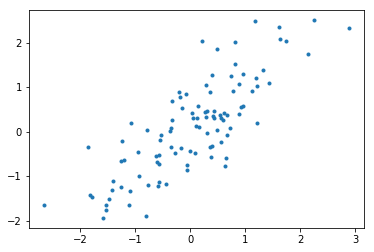

In [51]:
n, p, rho = 100, 2, .8
beta = np.random.normal(0,1,p)
sigma = 1.
X, y = sim_corr_lm(n,p,rho,beta,sigma)
plt.plot(X[:,0],X[:,1],'.')

In [52]:
def sample_coef_corr_lm(trials,**kwargs):
    """
    Sample the OLS coefficients for rho correlated input
    """
    beta_sim = []
    for t in range(trials):
        X,y = sim_corr_lm(**kwargs)
        beta_sim += [linear_model.LinearRegression(fit_intercept=False).fit(X,y).coef_]
    return np.array(beta_sim)

Text(0, 0.5, 'beta variance')

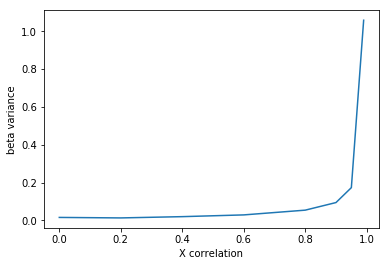

In [62]:
## Sample coefficients with different rho and plot variance of beta_1 as rho increases
Rhos = [0,.2,.4,.6,.8,.9,.95,.99]
coef_vars = [sample_coef_corr_lm(100,n=n,p=p,rho=rho,beta=beta,sigma=sigma)[:,0].var(axis=0) for rho in Rhos]
plt.plot(Rhos,coef_vars)
plt.xlabel('X correlation')
plt.ylabel('beta variance')

### Singular value decomposition

- Recall that QR decomposition was computed to make LinearRegression.fit easier.
- There are other decompositions that can also be used: Cholesky and Singular Value.

**Singular Value Decomposition** (for $n > p$ and $X^\top X$ invertible)

$$
X = U D V^\top,
$$
- U is orthonormal ($U^\top U = I$) $n \times p$
- V is orthonormal $p \times p$
- D is diagonal


1. If X is singular, there is a non-zero vector $z$ such that $Xz = 0$, then an eigenvalue is $0$.  This is equivalent to a residual in Succ. Ortho. being zero.
2. Computing SVD is more expensive then QR in general.

### Singular Value Decomposition

Suppose that we precomputed the SVD,
$$
X = UDV^\top.
$$
Then the Gram matrix is 
$$
X^\top X = V D U^\top U D V^\top = V D^2 V^\top,
$$
the Spectral decomposition.

In homework 1, you should derive that 
$$
\hat \beta = V D^{-1} U^\top y
$$

Hint: show that $(X^\top X)^{-1} = V D^{-2} V^\top$

### Singular Value Decomposition

The coefficient formula
$$
\hat \beta = V D^{-1} U^\top y
$$
means that 
$$
\hat \beta = \sum_{j=0}^p d_j^{-1} (u_j^\top y) v_j 
$$
which means that 

> $\hat \beta$ is instable (high variance in some direction) if the eigenvalues are very small.

In [105]:
## Simulate again
n, p, rho = 100, 8, .8
beta = np.random.normal(0,1,p)
sigma = 1.
X, y = sim_corr_lm(n,p,rho,beta,sigma)

## SVD
U,d,Vt = sc.linalg.svd(X)

## Check to make sure that we understand
print(U.shape, Vt.shape, d.shape)
np.abs(X - U[:,:p] @ np.diag(d) @ Vt).sum()

(100, 100) (8, 8) (8,)


1.558768684874895e-12

In [103]:
## Sample coefficients with different rho and store eigenvalues and beta variances
Rhos = [0,.2,.4,.6,.8,.9,.95,.99]
res_mat = []
for rho in Rhos:
    X, y = sim_corr_lm(n,p,rho,beta,sigma)
    U,d,Vt = sc.linalg.svd(X)
    res_mat += [d]

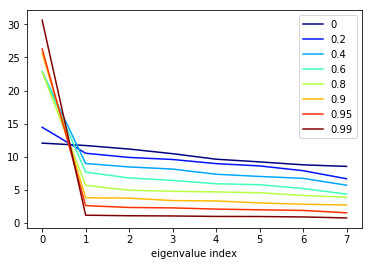

In [104]:
## plot the ordered eigenvalues for each rho
colors = plt.cm.jet(np.linspace(0,1,len(Rhos)))
for col, rho, res_vec in zip(colors,Rhos,res_mat):
    plt.plot(res_vec,label=str(rho),c=col)
plt.legend()
_ = plt.xlabel('eigenvalue index')

### Ridge regression

We can summarize the above statements as
> If X is nearly singular then $\hat \beta$ is instable

One solution is *Ridge regression*, $\hat \beta$ that solves
$$
\min. \sum_{i=1}^n (y_i - x_i^\top \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2.
$$

- Ridge regularization will "pull" $\beta$ towards 0.
- $\lambda$ is a tuning parameter and the second term is ridge penalty
- centered $X$ ($x_{i,j} \gets x_{i,j} - \bar x_j$ for all but intercept) then $\hat \beta_0 = \bar y$, can then remove the intercept from $y$ and perform ridge with $\beta$ without intercept
- normalize $X$ ($x_{i,j} \gets x_{i,j} / \| x_j \|$) makes all penalty terms on same scale

### Ridge regression

Ridge objective (with no intercept)
$$
(y - X \beta)^\top (y - X \beta) + \lambda \beta^\top \beta
$$
is proportional to 
$$
- 2 y^\top X \beta + \beta^\top (X^\top X) \beta + \lambda \beta^\top \beta = -2 (X^\top y)^\top \beta + \beta^\top (X^\top X + \lambda I) \beta.
$$
The ridge solution satisfies some new normal equations,
$$
(X^\top X + \lambda I) \hat \beta = X^\top y.
$$
> Ridge regularization always has a solution because $(X^\top X + \lambda I)^{-1}$ exists!

### Ridge regression and SVD

If $X = U D V^\top$ then 
$$
X^\top X + \lambda I = V D^2 V^\top + \lambda I = V (D^2 + \lambda I) V^\top 
$$
because when $p < n$ then $V V^\top = I$.
So Ridge solution can be shown to be (exercise)
$$
\hat \beta = V (D^2 + \lambda I)^{-1} D U^\top y 
$$
compare to OLS
$$
\hat \beta = V D^{-1} U^\top y 
$$
modifies the eigenvalues to be 
$$
d_j \gets \frac{d_j^2 + \lambda}{d_j}
$$
but but but Ridge regression is biased!

<img src="ridge_bias.PNG" width=70%>

### Subset selection

Two motivations for selecting variables
1. Fewer variabbles can lead to lower risk
2. We want to discover a subset of variables with large effects

A model for *sparsity*
$$
y_i = x_i^\top \beta + \epsilon_i
$$
where for some of the $j = 1,\ldots,p$, $\beta_j = 0$.

**Def** Support of $\beta$ is 
$$
\textrm{supp}(\beta) = \{j = 1,\ldots,p : \beta_j \ne 0 \}.
$$
then goal is to find supp$(\beta)$ or $\beta$ such that $|$supp$(\beta)| \le s$.

### Computational challenges of subset selection

*Combinatorial ($L_0$) subset selection:* Select $S \subseteq \{1,\ldots, p\}$ s.t. $|S| \le s$ and minimizes
$$
\sum_{i=1}^n \left(y_i - \sum_{j \in S} x_{i,j} \beta_j \right)^2
$$

This optimization is NP hard in general!

**Def** $L_0$ norm (not a norm), is $\|\beta\|_0 = {\rm supp}(\beta)$.

Then subset selection is
$$
\min \| y - X \beta \|^2 \textrm{ s.t. } \beta \in \mathbb R^p, \| \beta \|_0 \le s
$$

### Greedy methods

Basic idea: at each step, choose an action that improves empirical risk

#### Forward Stepwise
- Input X standardized, $x_0 = 1$, y
- Let $S_0 = {0}$
- For $s = 1,\ldots, p$:
 - For $j \notin S$:
  $$ R_j = \min \| y - X \beta \|^2 \textrm{ s.t. supp}(\beta) = S_{s-1} \cup \{ j \} $$
 - Add minimizer of $R_j$ to $S_{s-1}$ update $S_s$   

- Intermediate OLS steps can be slow
- Correlations can cause issues: add a variable early on only because it is correlated with significant vars, never lose it